### Tree Data Preparation

This notebook demonstrates how to prepare the input for FiTree using the AML trees from [Morita et al., 2020](https://www.nature.com/articles/s41467-020-19119-8). 

#### 1. Load necessary packages

In [1]:
import pandas as pd
import numpy as np
from pyfaidx import Fasta
import matplotlib.pyplot as plt
from fitree import (
    Subclone, 
    TumorTree, 
    TumorTreeCohort, 
    save_cohort_to_json, 
    load_cohort_from_json,
    plot_tree,
)

#### 2. Load the dataframe of tumor mutation trees

The following columns are necessary for the tree preparation:
- Patient: patient labels in text
- Mutation: mutation labels in text
- Patient_ID: patient IDs
- Tree_ID: tree IDs (one patient can have multiple trees)
- Node_ID: IDs of each node/subclone in the tree
- Mutation_ID: mutation IDs
- Parent_ID: IDs of the parent nodes (Parent_ID = 0 means that the parent is the root)
- Age: ages of the patients
- Total_Cells: total number of tumor cells. This value should be estimated from clinical data. For AML, the formula is

$$
\begin{split}
    & \quad \text{PB\_WBC} \times \text{PB\_Blast} \times \text{Average adult blood volume} \\
    & + \text{BM\_Blast} \times \text{Average adult bone marrow mononuclear cell count}
\end{split}
$$


- Sequenced_Cells: number of cells attached to the node/subclone

In [2]:
AML_tree_df_combined = pd.read_csv('../data/AML_tree_df_Morita_2020.csv')

In [3]:
AML_tree_df_combined.head()

,Patient,Mutation,Node_ID,Mutation_ID,Parent_ID,Patient_ID,Tree_ID,Age,Total_Cells,Sequenced_Cells
0,AML-01-001,FLT3,1,0,0,0,0,66,9.490000e+11,390
1,AML-01-001,WT1,2,2,1,0,0,66,9.490000e+11,3378
2,AML-01-001,NPM1,3,1,2,0,0,66,9.490000e+11,7306
3,AML-02-001,DNMT3A,1,3,0,1,0,84,2.090000e+11,529
4,AML-02-001,SF3B1,2,16,1,1,0,84,2.090000e+11,262


#### 3. Process data and estimate static parameters

We assume that evolution begins once the HSC reserve fills, average around 18 years, which is subtracted from the patients’ ages at diagnosis to get the sampling times ts of the tumors.

In [4]:
AML_tree_df_combined["Sampling_Time"] = AML_tree_df_combined["Age"] - 18

The population of human hematopoietic stem cells (HSCs) grows from birth through adolescence and then stabilizes, resulting in a relatively static population with an average of approximately $C_0 = 10^5$ wild-type cells, which we model as the root in our framework.

In [5]:
C_0 = 1e5

The maximum observation time $t_{\max}$ is then set as the maximum of the sampling times.

In [6]:
t_max = np.max(AML_tree_df_combined["Sampling_Time"])

We take the common death rate $\beta = 1.0$ to match roughly the average birth rate of HSCs.

In [7]:
common_beta = 1.0

The lifetime risk of AML is approximately 0.5% according to [SEER](https://seer.cancer.gov/statfacts/html/amyl.html).

In [8]:
lifetime_risk = 0.005

The scaling factor $C_{\text{sampling}}$ is taken to be the mean of the tumor sizes.

In [9]:
C_sampling = np.mean(AML_tree_df_combined["Total_Cells"].unique()) 

In [10]:
C_sampling

455248214285.7143

##### 3.1 Determine mutation rates

We first load the variants information provided by [Morita et al., 2020](https://www.nature.com/articles/s41467-020-19119-8). This dataframe lists all the variants detected in the cohort and indicates whether they are SNVs.

In [11]:
AML_variants = pd.read_csv('../data/AML_variants_Morita_2020.csv')

In [12]:
AML_variants.head()

,sample ID,gene,chr,start,ref allele,alt allele,amino acid change,function,exonic function,mutated %,scDNA-seq VAF,WT\n(No. of cells),Het\n(No. of cells),Homo\n(No. of cells),Missing\n(No. of cells),validated,validation method,bulk VAF
0,AML-01-001,FLT3,13,28608259,X,XAACTCTAAATTTTCTCTTGGAAACTCCCATTTGAGATCATATTCA...,p.Y599_D600delinsX,exonic,stopgain,0.9352,0.7949,239,8444,2190,498,yes,bulk-NGS,0.1186
1,AML-01-001,NPM1,5,170837544,T,TCTGC,p.L287fs,exonic,frameshift insertion,0.4249,0.4608,1285,4226,606,5254,yes,bulk-NGS,0.1828
2,AML-01-001,WT1,11,32417913,C,CGTACAAGA,p.R380fs,exonic,frameshift insertion,0.0034,0.0015,10779,39,0,553,yes,bulk-NGS in paired sample,0
3,AML-01-001,WT1,11,32417943,C,CG,p.R370fs,exonic,frameshift insertion,0.8836,0.4865,568,9799,248,756,yes,bulk-NGS,0.236
4,AML-02-001,DNMT3A,2,25457242,C,T,p.R882H,exonic,nonsynonymous SNV,0.7603,0.4639,468,5861,169,1433,yes,bulk-NGS,0.4239


Next, we import the haploid trinucleotide-context-site-specific mutation rates from [Watson et al., 2020](https://www.science.org/doi/10.1126/science.aay9333).

In [13]:
site_mutation_rates = pd.read_csv("../data/trinucleotide_mutation_rates_Watson_2020.csv")

In [14]:
site_mutation_rates.head()

,Site,Mutation_rate
0,A[C>A]A,1.332230e-09
1,A[C>A]C,9.481170e-10
2,A[C>A]G,1.064910e-09
3,A[C>A]T,7.585960e-10
4,C[C>A]A,1.538010e-09


Then we need the human genome asembly file (hg19), which needs to be downloaded from [here](https://www.gencodegenes.org/human/release_19.html) and saved to the same folder with name "GRCh37.p13.genome.fa".

In [15]:
hg19_fasta = Fasta("../data/GRCh37.p13.genome.fa")

For each AML variant, check whether it is an SNV. If yes, then query the trinucleotide context from the fasta file based on the columns "chr" and "start" and determine its haploid trinucleotide-context-site-specific mutation rate.

In [16]:
AML_variants["tri_context"] = ""
AML_variants["site_specific_mutation_rate"] = 0.0
for index, row in AML_variants.iterrows():
	if row["exonic function"] == "nonsynonymous SNV":
		chrom = "chr" + row["chr"]
		start = row["start"] - 2
		end = row["start"] + 1
		sequence = hg19_fasta[chrom][start:end]
		p0 = sequence[0]
		p1 = sequence[1]
		p2 = sequence[2]
		tri_context = f"{p0}[{p1}>{row['alt allele']}]{p2}"
		tri_rate = site_mutation_rates[site_mutation_rates["Site"] == tri_context]["Mutation_rate"].values[0]
		AML_variants.at[index, "tri_context"] = tri_context
		AML_variants.at[index, "site_specific_mutation_rate"] = tri_rate

For all other variants, we assign an average mutation rate of $2.7 × 10^{−9}$ per bp per year.

In [17]:
AML_variants["site_specific_mutation_rate"] = AML_variants["site_specific_mutation_rate"].replace(0.0, 2.7e-9)

Get all unique combinations of (gene, amino acid change, site_specific_mutation_rate):

In [18]:
AML_variants_unique = AML_variants.drop_duplicates(subset=["gene", "amino acid change", "ref allele", "alt allele", "site_specific_mutation_rate"])
AML_variants_unique = AML_variants_unique[["gene", "amino acid change", "ref allele", "alt allele", "exonic function", "site_specific_mutation_rate"]]

In [19]:
AML_variants_unique.query("gene == 'TET2'")

,gene,amino acid change,ref allele,alt allele,exonic function,site_specific_mutation_rate
50,TET2,p.P1215L,C,T,nonsynonymous SNV,4.379090e-09
98,TET2,p.E375X,G,T,stopgain,2.700000e-09
318,TET2,splicing,G,A,.,2.700000e-09
319,TET2,p.H1889Y,C,T,nonsynonymous SNV,9.919690e-10
323,TET2,p.G1882R,G,A,nonsynonymous SNV,2.646110e-09
360,TET2,p.I274fs,TC,T,frameshift deletion,2.700000e-09
384,TET2,p.Q1009X,C,T,stopgain,2.700000e-09
386,TET2,p.E1534K,G,A,nonsynonymous SNV,4.379090e-09
401,TET2,p.S1267X,C,A,stopgain,2.700000e-09
410,TET2,p.Q866X,C,T,stopgain,2.700000e-09


For each gene, sum up the site-specific mutation rates.

In [20]:
AML_variants_sum = AML_variants_unique.groupby("gene").agg({"site_specific_mutation_rate": "sum"}).reset_index()

In [21]:
AML_variants_sum

,gene,site_specific_mutation_rate
0,ASXL1,2.430000e-08
1,BCOR,1.350000e-08
2,CBL,1.630361e-08
3,CSF3R,2.700000e-09
4,DNMT3A,1.137878e-07
5,ETV6,2.700000e-09
6,EZH2,5.053607e-08
7,FLT3,1.297272e-07
8,GATA2,6.238082e-09
9,IDH1,4.526963e-08


In [ ]:
# save the AML variants to a file
AML_variants_sum.to_csv("../data/AML_mutation_rates.csv", index=False)

In [22]:
AML_variants_sum_dict = dict(zip(AML_variants_sum["gene"], AML_variants_sum["site_specific_mutation_rate"]))

In [23]:
AML_variants_sum_dict

{'ASXL1': 2.4300000000000003e-08,
 'BCOR': 1.3500000000000002e-08,
 'CBL': 1.630361e-08,
 'CSF3R': 2.7e-09,
 'DNMT3A': 1.13787835e-07,
 'ETV6': 2.7e-09,
 'EZH2': 5.0536069e-08,
 'FLT3': 1.29727249e-07,
 'GATA2': 6.238082000000001e-09,
 'IDH1': 4.526963e-08,
 'IDH2': 1.853029e-08,
 'JAK2': 1.33223e-09,
 'KIT': 4.53317e-10,
 'KRAS': 4.9253573e-08,
 'MPL': 1.41512e-08,
 'MYC': 1.5770254e-08,
 'NPM1': 1.3500000000000002e-08,
 'NRAS': 2.0343801e-08,
 'PHF6': 1.4704399999999999e-08,
 'PPM1D': 8.1e-09,
 'PTPN11': 1.8543133e-08,
 'RUNX1': 1.2800741e-07,
 'SETBP1': 1.20044e-08,
 'SF3B1': 2.241882e-09,
 'SMC3': 4.83263e-10,
 'SRSF2': 4.372184e-09,
 'STAG2': 8.1e-09,
 'TET2': 6.021958100000001e-08,
 'TP53': 5.1095175e-08,
 'U2AF1': 2.69811e-09,
 'WT1': 9.68503e-08}

#### 4. Prepare trees

Now we are ready to parse the trees. We loop through the tree dataframe. For each patient, create a *TumorTree* object by first creating a root node and then adding all the other nodes as *Subclone*.

In [24]:
trees = []

for patient_id in AML_tree_df_combined["Patient_ID"].unique():
	patient_df = AML_tree_df_combined[AML_tree_df_combined["Patient_ID"] == patient_id]
	sampling_time = patient_df["Sampling_Time"].iloc[0]
	tree_id = patient_df["Tree_ID"].iloc[0]
	root_node = Subclone(node_id=0, mutation_ids=[], seq_cell_number=C_0)  # pyright: ignore
	node_dict = {0: root_node}

	# Loop through rows of patient_df
	for index, row in patient_df.iterrows():
		new_node = Subclone(
			node_id=row["Node_ID"],
			mutation_ids=[row["Mutation_ID"]],
			seq_cell_number=row["Sequenced_Cells"],
			parent=node_dict[row["Parent_ID"]],
		)
		node_dict[row["Node_ID"]] = new_node
	
	tree = TumorTree(
		patient_id=patient_id,
		tree_id=tree_id,
		sampling_time=sampling_time,
		root=root_node,
		tumor_size=patient_df["Total_Cells"].iloc[0],
	)
	trees.append(tree)


Finally, we construct the *TumorTreeCohort* object.

In [25]:
name = "AML_cohort_Morita_2020"
n_mutations = AML_tree_df_combined["Mutation_ID"].nunique()
N_patients = AML_tree_df_combined["Patient_ID"].nunique()
N_trees = N_patients
mutation_labels = AML_tree_df_combined[["Mutation_ID", "Mutation"]].drop_duplicates().sort_values("Mutation_ID")["Mutation"].values
patient_labels = AML_tree_df_combined[["Patient_ID", "Patient"]].drop_duplicates().sort_values("Patient_ID")["Patient"].values
tree_labels = patient_labels
mu_vec = np.array([AML_variants_sum_dict.get(mutation, 0.0) for mutation in mutation_labels])

In [26]:
AML_cohort = TumorTreeCohort(
	name=name,
	trees=trees,
	n_mutations=n_mutations,
	N_patients=N_patients,
	N_trees=N_trees,
	mu_vec=mu_vec,
	common_beta=common_beta,
	C_0=C_0,
	C_sampling=C_sampling,
	t_max=t_max,
	mutation_labels=mutation_labels,
	patient_labels=patient_labels,
	tree_labels=tree_labels,
	lifetime_risk=lifetime_risk,
)

The followings are two i/o functions:

In [ ]:
save_cohort_to_json(AML_cohort, "../data/AML_cohort_Morita_2020.json")

In [27]:
AML_cohort = load_cohort_from_json("../data/AML_cohort_Morita_2020.json")

There are two print/plot functions:

In [28]:
print(AML_cohort.trees[0])

Tumor tree 0 of patient                 0 at time 48
 - Total number of tumor cells: 9.4900E+11
(Node ID: 0) 
 - Mutations: [] 
 - Cell number: 1.0000E+05 
 - Sequence cell number: 1.0000E+05 
└── (Node ID: 1) 
     - Mutations: [0] 
     - Cell number: 3.3422E+10 
     - Sequence cell number: 3.9000E+02 
    └── (Node ID: 2) 
         - Mutations: [2] 
         - Cell number: 2.8948E+11 
         - Sequence cell number: 3.3780E+03 
        └── (Node ID: 3) 
             - Mutations: [1] 
             - Cell number: 6.2610E+11 
             - Sequence cell number: 7.3060E+03 


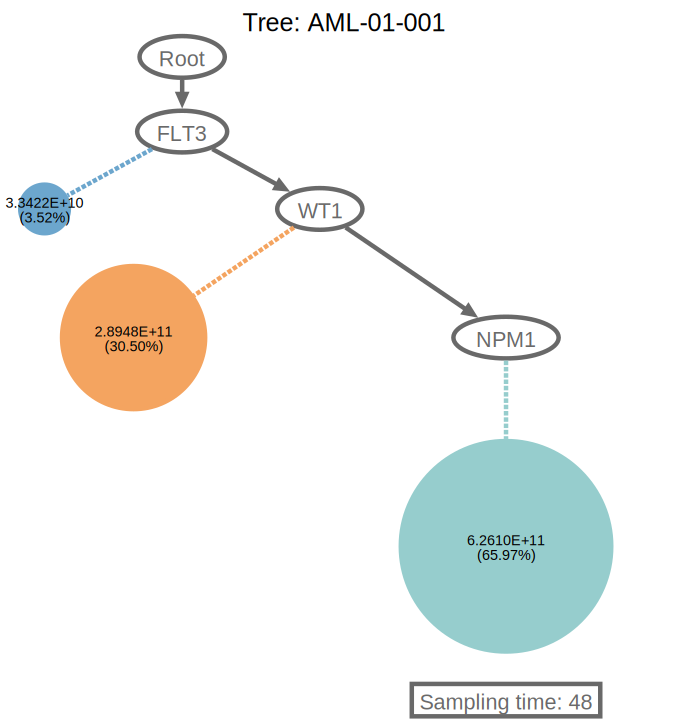

In [29]:
i = 0
plot_tree(AML_cohort, i)